In [1]:
import cv2
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import math



# Face Detection

In [2]:
img_path = "/Users/avinash/Desktop/Facial Recognition/sample/my_photo.jpeg"

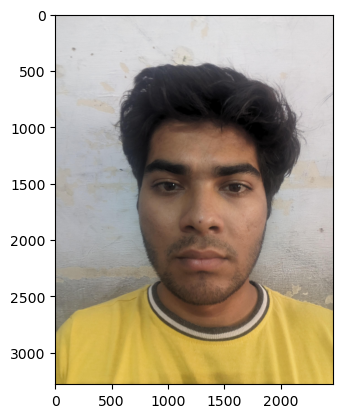

In [3]:
bgr_img = cv2.imread(img_path)
rgb_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_img)

In [4]:
# detecting face

opencv_dnn_model = cv2.dnn.readNetFromCaffe(prototxt="detection_model/deploy.prototxt",                      
                                     caffeModel="detection_model/Widerface-RetinaFace.caffemodel")
opencv_dnn_model

< cv2.dnn.Net 0x174eba310>

In [5]:
blob = cv2.dnn.blobFromImage(bgr_img, scalefactor=1.0, size=(224,224), mean=(104.0, 177.0, 123.0), swapRB=False)
    
opencv_dnn_model.setInput(blob)
detections = opencv_dnn_model.forward()

In [6]:
detections

array([[[[0.        , 1.        , 0.29261023, ..., 0.31827092,
          0.7677976 , 0.79855657],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ]]]], dtype=float32)

In [7]:
detections.shape
# batch-size, fixed-dimension, no. of detecions, data-for-each-detection

"""
batch_size ==> the number of images processed in one forward pass through the network.
fixed-dimension ==> this is a fixed dimension in certain network outputs.
                    used for internal consistency or based on how the model was trained
no. of detctions ==> number of objects detected in the image. 
                     Each entry along this dimension represents a detected object.
data for each detection ==> Index 0: The image ID
                            Index 1: The class ID
                            Index 2: The confidence score for the detection.
                            Indexes 3 to 6: The coordinates of the bounding box.[x1, y1, x2, y2]

"""
 

'\nbatch_size ==> the number of images processed in one forward pass through the network.\nfixed-dimension ==> this is a fixed dimension in certain network outputs.\n                    used for internal consistency or based on how the model was trained\nno. of detctions ==> number of objects detected in the image. \n                     Each entry along this dimension represents a detected object.\ndata for each detection ==> Index 0: The image ID\n                            Index 1: The class ID\n                            Index 2: The confidence score for the detection.\n                            Indexes 3 to 6: The coordinates of the bounding box.[x1, y1, x2, y2]\n\n'

In [8]:
detections.shape[2]

200

In [9]:
detections[0, 0, 199, 2]

0.0

In [10]:
h,w = bgr_img.shape[:2]

In [11]:
print("h ->",h, ", w ->",w)

h -> 3280 , w -> 2464


In [12]:
 detections[0,0,0,2]

0.29261023

(x1,y1) ->  (727, 1043) (x2,y2) -> (1891, 2619)


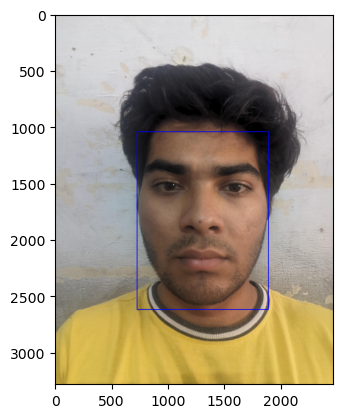

In [13]:
threshold=0.2


for i in range(detections.shape[2]):
    confidence = detections[0,0,i,3]
    if confidence > threshold:
        
        box = detections[0,0,i,3:7]
        x1 = int(box[0] * w)
        y1 = int(box[1] * h)
        x2 = int(box[2] * w)
        y2 = int(box[3] * h)
        
        print("(x1,y1) -> ",(x1,y1),"(x2,y2) ->",(x2,y2))
        
        # drawing bbox
        cv2.rectangle(rgb_img, (x1,y1), (x2,y2), (0,0,255), 6)


plt.imshow(rgb_img)

In [14]:
detections[0,0,0,3:]

array([0.29519784, 0.31827092, 0.7677976 , 0.79855657], dtype=float32)

### Cropping the face-out

In [15]:
import os
import cv2
import math

class PatchCreation:
    
    def __init__(self, dir_folder_path, extensions=('jpg', 'jpeg', 'png')):
        self.dir_folder_path = dir_folder_path
        self.extensions = extensions
        
        
    # Bounding Box for Facial Detection
    def get_bbox(self, img):
        height, width = img.shape[0], img.shape[1]
        aspect_ratio = width / height
        if img.shape[1] * img.shape[0] >= 192 * 192:
            img = cv2.resize(img,
                             (int(192 * math.sqrt(aspect_ratio)),
                              int(192 / math.sqrt(aspect_ratio))), interpolation=cv2.INTER_LINEAR)

        blob = cv2.dnn.blobFromImage(img, 1, mean=(104, 117, 123))
        opencv_dnn_model.setInput(blob, 'data')
        out = opencv_dnn_model.forward('detection_out').squeeze()
        max_conf_index = np.argmax(out[:, 2])
        left, top, right, bottom = out[max_conf_index, 3]*width, out[max_conf_index, 4]*height, \
                                   out[max_conf_index, 5]*width, out[max_conf_index, 6]*height
        bbox = [int(left), int(top), int(right-left+1), int(bottom-top+1)]

        # cv2.rectangle(image, start_point, end_point, color, thickness)
        cv2.rectangle(img, (bbox[0], bbox[1]), (bbox[2],bbox[3]), (0, 255, 0), 2)

        # not converting the color of img from BGR -> RGB
        # because no use of displaying it, here the img is only used for cropping and scaling after detection
        return bbox
   

In [16]:
patch_creation = PatchCreation(img_path)

In [17]:
bbox = patch_creation.get_bbox(bgr_img)
bbox

[661, 1143, 1298, 1353]

In [18]:
class CropImage:
    @staticmethod
    def _get_new_box(src_w, src_h, bbox, scale):
        x = bbox[0]
        y = bbox[1]
        box_w = bbox[2]
        box_h = bbox[3]

        scale = min((src_h-1)/box_h, min((src_w-1)/box_w, scale))

        new_width = box_w * scale
        new_height = box_h * scale
        center_x, center_y = box_w/2+x, box_h/2+y

        left_top_x = center_x-new_width/2
        left_top_y = center_y-new_height/2
        right_bottom_x = center_x+new_width/2
        right_bottom_y = center_y+new_height/2

        if left_top_x < 0:
            right_bottom_x -= left_top_x
            left_top_x = 0

        if left_top_y < 0:
            right_bottom_y -= left_top_y
            left_top_y = 0

        if right_bottom_x > src_w-1:
            left_top_x -= right_bottom_x-src_w+1
            right_bottom_x = src_w-1

        if right_bottom_y > src_h-1:
            left_top_y -= right_bottom_y-src_h+1
            right_bottom_y = src_h-1

        return int(left_top_x), int(left_top_y),\
               int(right_bottom_x), int(right_bottom_y)

    def crop(self, org_img, bbox, scale, out_w, out_h, crop=True):

        if not crop:
            dst_img = cv2.resize(org_img, (out_w, out_h))
            print("Not able to Crop")
        else:
            src_h, src_w, _ = np.shape(org_img)
            left_top_x, left_top_y, \
                right_bottom_x, right_bottom_y = self._get_new_box(src_w, src_h, bbox, scale)

            img = org_img[left_top_y: right_bottom_y+1,
                          left_top_x: right_bottom_x+1]
            dst_img = cv2.resize(img, (out_w, out_h))
            
            dst_img = cv2.cvtColor(dst_img,cv2.COLOR_BGR2RGB)
            
            print("Crop successfull")
        return dst_img


In [19]:
crop_img = CropImage()

In [20]:
bgr_img.shape

(3280, 2464, 3)

In [21]:
face = crop_img.crop(org_img = bgr_img , bbox=bbox, scale=1.0, out_w=bgr_img.shape[1], out_h=bgr_img.shape[0])

Crop successfull


Text(0.5, 1.0, 'Face Detection')

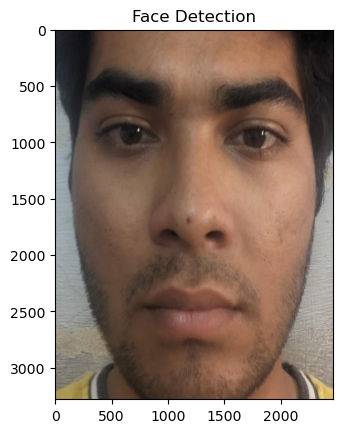

In [22]:
plt.imshow(face);plt.title("Face Detection")

# Patch-based

##### Using Eye Detector

##### It will fail - Eyes not detected or less than two eyes detected.

In [23]:

# # Assume these are your coordinates for the detected face from the Caffe model
# bbox = (x, y, w, h)  # Update these with your actual coordinates

# # Extract the face ROI
# face_roi = bgr_img[y:y+h, x:x+w]
# gray_face_roi = cv2.cvtColor(face_roi, cv2.COLOR_BGR2GRAY)

# # Load the Haar Cascade for eye detection
# eye_cascade = cv2.CascadeClassifier(haar_cascade_path)
# eyes = eye_cascade.detectMultiScale(gray_face_roi, 1.1, 12)  # Adjust parameters as needed

# # Check if eyes were detected
# if len(eyes) >= 2:
#     # Sort eyes by x coordinate
#     sorted_eyes = sorted(eyes, key=lambda b: b[0])
#     # Calculate coordinates for the eye patch
#     x1, y1, w1, h1 = sorted_eyes[0]
#     x2, y2, w2, h2 = sorted_eyes[1]
    
#     # Define padding
#     padding_top = 100  # Padding on top to include eyebrows and forehead
#     padding_sides = 100  # Padding on sides for wider facial context
#     padding_bottom = 500  # Padding on the bottom

#     # Calculate extended coordinates with padding
#     start_x = max(x1 - padding_sides, 0)
#     end_x = min(x2 + w2 + padding_sides, w)
#     start_y = max(y1 - padding_top, 0)
#     end_y = min(y2 + h2 + padding_bottom, h)
    
#     # Extract eye patch
#     eye_patch = face_roi[start_y:end_y, start_x:end_x]
#     eye_patch = cv2.cvtColor(eye_patch, cv2.COLOR_BGR2RGB)
#     plt.imshow(eye_patch); plt.title('Extended Eye Patch')
#     plt.show()
# else:
#     print("Eyes not detected or less than two eyes detected.")


This approach assumes a fairly frontal face position and might not work as well with profiles or tilted heads.

When detecting facial features using a fixed proportion of the face bounding box (such as the upper third for the eyes), the method works under the assumption that the face is oriented directly towards the camera.

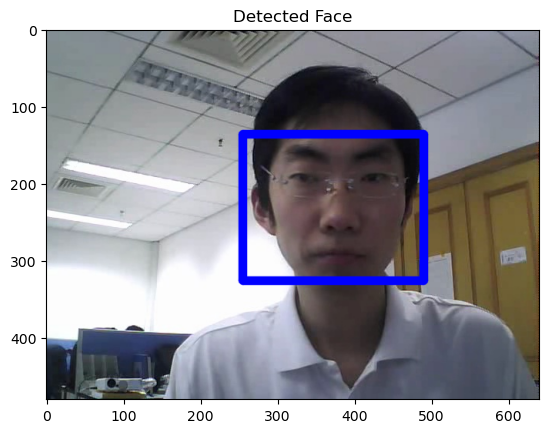

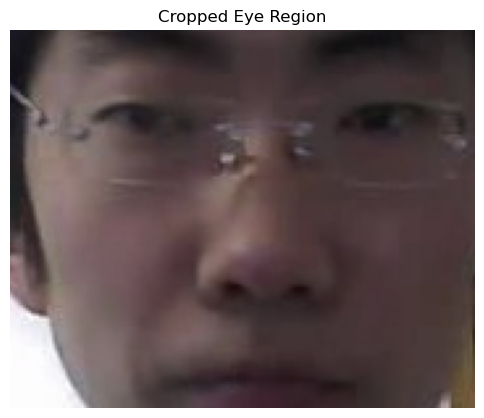

In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img_path = "/Users/avinash/Desktop/Facial Recognition/extracted_frames/frame_149.jpg"
bgr_img = cv2.imread(img_path)
rgb_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
# plt.imshow(rgb_img)

# Load the Caffe model
opencv_dnn_model = cv2.dnn.readNetFromCaffe(prototxt="detection_model/deploy.prototxt",                      
                                     caffeModel="detection_model/Widerface-RetinaFace.caffemodel")

# Prepare the image for the CNN
blob = cv2.dnn.blobFromImage(bgr_img, scalefactor=1.0, size=(224, 224), mean=(104.0, 177.0, 123.0), swapRB=False)
opencv_dnn_model.setInput(blob)
detections = opencv_dnn_model.forward()

h, w = bgr_img.shape[:2]
threshold = 0.2

for i in range(detections.shape[2]):
    confidence = detections[0, 0, i, 2]
    if confidence > threshold:
        box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
        (x1, y1, x2, y2) = box.astype("int")
        
        cv2.rectangle(rgb_img, (x1,y1),(x2,y2),(0,0,255),10, cv2.LINE_AA)
        plt.imshow(rgb_img)
        plt.title("Detected Face")
        plt.show()


        # Estimate eye region, typically around the upper middle third
        eye_region_height = (y2 - y1) // 8
        eye_region_y1 = y1 + eye_region_height
        eye_region_y2 = y2 - eye_region_height
        eye_region_width = (x2 - x1) // 8
        eye_region_x1 = x1 + eye_region_width
        eye_region_x2 = x2 - eye_region_width

        # Crop to the estimated eye region
        eye_region = rgb_img[eye_region_y1:eye_region_y2, eye_region_x1:eye_region_x2]
        plt.figure(figsize=(6, 6))
        plt.imshow(eye_region)
        plt.title("Cropped Eye Region")
        plt.axis('off')
        plt.show()

# # # Display the final result with detected region
# plt.imshow(rgb_img)
# plt.title("Detected Face")
# plt.show()


In [25]:
# eye_region

## Patches Creation

##### No-overlapping patches

In [26]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

# Assuming 'eye_region' is your cropped eye region image
eye_height, eye_width, _ = eye_region.shape

# Define the patch size
patch_size = 96

# Check if the eye region is large enough
if eye_height < patch_size or eye_width < patch_size:
    print("Eye region is too small for 96x96 patches. Consider resizing.")
else:
    patches = []  # List to store the patches
    for i in range(6):  # Generate 6 random patches
        # Randomly select the top left corner of the patch
        x = random.randint(0, eye_width - patch_size)
        y = random.randint(0, eye_height - patch_size)

        # Extract the patch
        patch = eye_region[y:y + patch_size, x:x + patch_size]
        patches.append(patch)




In [27]:
# Displaying the patches

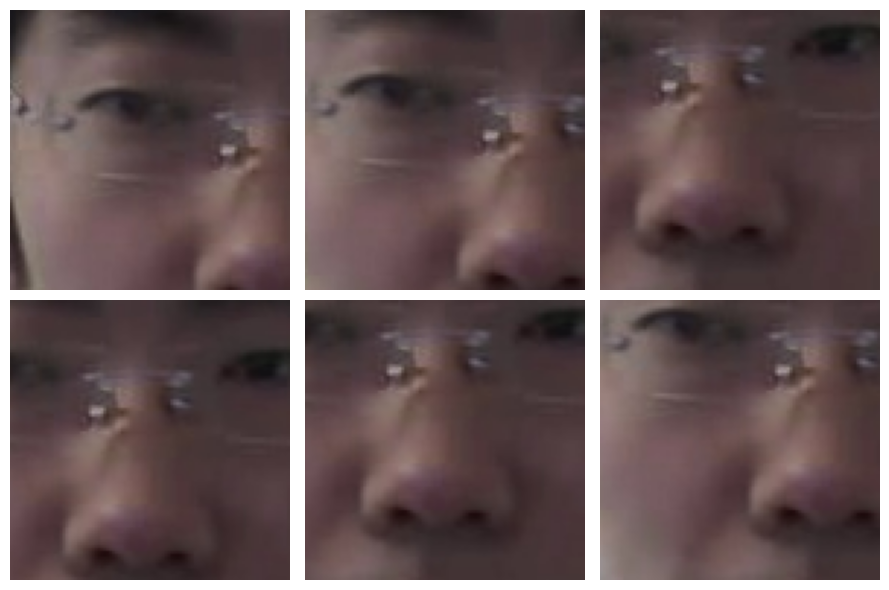

In [28]:
# Assuming 'patches' is a list of image arrays
num_patches = len(patches)

# Calculate the grid size: Aim for a square that fits all patches
cols = int(math.ceil(math.sqrt(num_patches)))
rows = int(math.ceil(num_patches / cols))

# Create a figure with subplots in a grid
fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))  # Adjust size as needed
axes = axes.ravel()  # Flatten the axes array if necessary

# Plot each patch
for i in range(num_patches):
    axes[i].imshow(patches[i])
    axes[i].axis('off')

# Hide unused axes if there are any
for ax in axes[num_patches:]:
    ax.axis('off')

plt.tight_layout()
plt.show()


##### Overlapping patches

In [102]:
# import cv2
# import numpy as np
# import matplotlib.pyplot as plt
# import random

# # Assuming 'eye_region' is your cropped eye region image
# eye_height, eye_width, _ = eye_region.shape

# # Define the patch size
# patch_size = 96

# patches = []  # List to store the patches
# for i in range(6):  # Generate 6 random patches
#     # Randomly select the top left corner of the patch
#     # Ensure there's some overlap by reducing the range slightly if the region is smaller than the patch size
#     x = random.randint(0, max(1, eye_width - patch_size))
#     y = random.randint(0, max(1, eye_height - patch_size))

#     # Adjust the end coordinate if it goes out of bounds
#     x_end = min(x + patch_size, eye_width)
#     y_end = min(y + patch_size, eye_height)

#     # Extract the patch
#     patch = eye_region[y:y_end, x:x_end]

#     # If the extracted patch is smaller than the desired size, resize it
#     if patch.shape[0] != patch_size or patch.shape[1] != patch_size:
#         patch = cv2.resize(patch, (patch_size, patch_size))

#     patches.append(patch)


In [103]:
# # Assuming 'patches' is a list of image arrays
# num_patches = len(patches)

# # Calculate the grid size: Aim for a square that fits all patches
# cols = int(math.ceil(math.sqrt(num_patches)))
# rows = int(math.ceil(num_patches / cols))

# # Create a figure with subplots in a grid
# fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))  # Adjust size as needed
# axes = axes.ravel()  # Flatten the axes array if necessary

# # Plot each patch
# for i in range(num_patches):
#     axes[i].imshow(patches[i])
#     axes[i].axis('off')

# # Hide unused axes if there are any
# for ax in axes[num_patches:]:
#     ax.axis('off')

# plt.tight_layout()
# plt.show()


In [105]:
def patch_based_model(input_shape):
    
    model = Sequential([
        # Convolution layer - 1
        Conv2D(filters=50, kernel_size=(5,5), strides=(1,1), activation="relu", input_shape=input_shape, padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2,2), strides=(2,2)),
        
        # Convolution layer - 2
        Conv2D(filters=100, kernel_size=(3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2,2), strides=(2,2)),
        
        # Convolution layer - 3
        Conv2D(filters=150, kernel_size=(3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(3,3), strides=(2,2)),
        
        # Convolution layer - 4
        Conv2D(filters=200, kernel_size=(3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2,2), strides=(2,2)),
        
        # Convolution layer - 5
        Conv2D(filters=250, kernel_size=(3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2,2), strides=(2,2)),
        
        Flatten(),
        
        Dense(units=1000, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        
        Dense(units=400, activation='relu'),
        BatchNormalization(),
        
        Dense(units=2, activation='softmax')
    ])
    
    
    
    return model


# Depth-based

# Color Spaces

In [39]:
live_path = "/Users/avinash/Desktop/live.jpeg"
replay_path = "/Users/avinash/Desktop/spoof.jpeg"
# print_path = "/Users/avinash/Desktop/Facial Recognition/sample/patch_based/print_attack.png"

In [40]:
live_img = cv2.imread(live_path)
replay_img = cv2.imread(replay_path)
# print_img = cv2.imread(print_path)

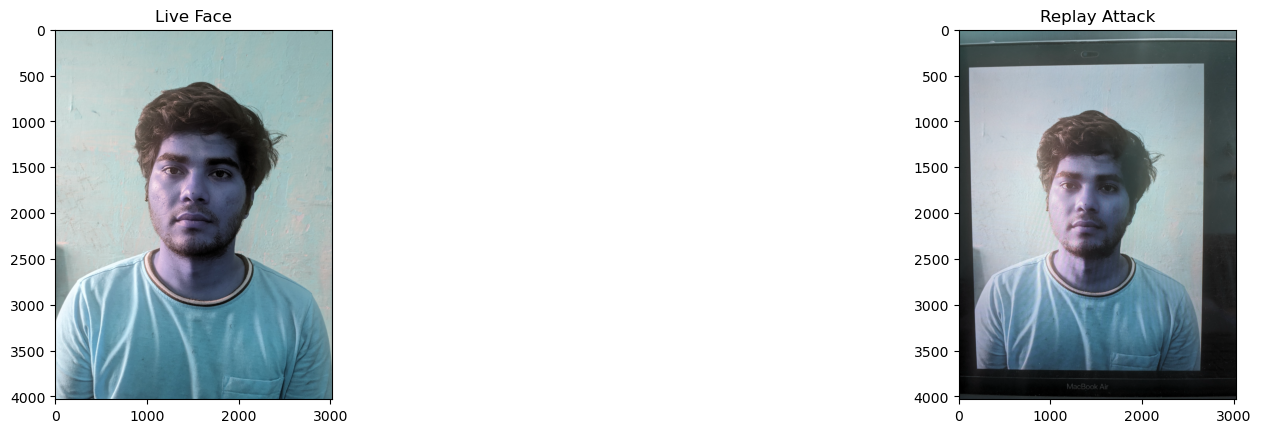

In [41]:
plt.subplot(131);plt.imshow(live_img);plt.title("Live Face");plt.subplots_adjust(left=1, right=3)
# plt.subplot(132);plt.imshow(print_img); plt.title("Print Attack");plt.subplots_adjust(left=1, right=3)
plt.subplot(133);plt.imshow(replay_img); plt.title("Replay Attack");plt.subplots_adjust(left=1, right=3)

plt.show()

In [42]:
live_patch = PatchCreation(live_path)
replay_patch = PatchCreation(replay_path)
# print_patch = PatchCreation(print_path)

In [43]:
live_face_bbox = patch_creation.get_bbox(live_img)
replay_attack_bbox = patch_creation.get_bbox(replay_img)
# print_attack_bbox = patch_creation.get_bbox(print_img)


In [44]:
live_face = crop_img.crop(org_img = live_img , bbox=live_face_bbox, scale=1.0, out_w=live_img.shape[1], out_h=live_img.shape[0])
replay_face = crop_img.crop(org_img = replay_img , bbox=replay_attack_bbox, scale=1.0, out_w=replay_img.shape[1], out_h=replay_img.shape[0])
# print_face = crop_img.crop(org_img = print_img , bbox=replay_attack_bbox, scale=1.0, out_w=print_img.shape[1], out_h=print_img.shape[0])

Crop successfull
Crop successfull


###        1. Examples on RGB (G channel), 
###        2. HSV (S channel), Y CbCr (Cb channel), 
###        3. pixel-wise LBP (LBP of S channel in HSV ), 
###        4. high-frequency images (using G in RGB) of both live and spoof face images.

In [45]:
# cv2.imshow("Live Face",live_face)
# cv2.imshow("Replay Face",replay_face)
# cv2.imshow("Print Face",print_face)

# cv2.waitKey(0)
# cv2.destroyAllWindows()


### RGB channel

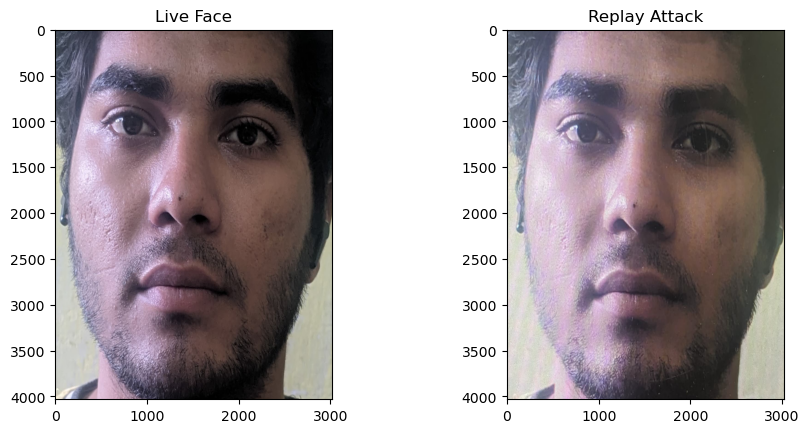

In [46]:
plt.subplot(131);plt.imshow(live_face);plt.title("Live Face");plt.subplots_adjust(left=1, right=3)
plt.subplot(132);plt.imshow(replay_face); plt.title("Replay Attack");plt.subplots_adjust(left=1, right=3)
# plt.subplot(133);plt.imshow(print_face); plt.title("Print Attack");plt.subplots_adjust(left=1, right=3)

plt.show()

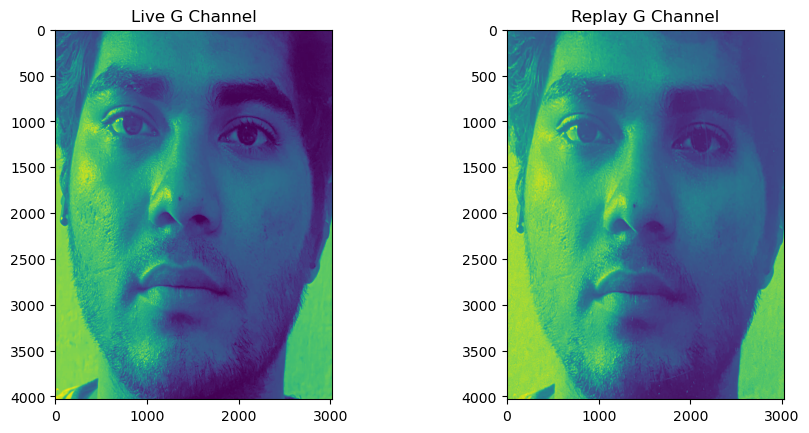

In [47]:
live_b, live_g, live_r = cv2.split(live_face)
replay_b, replay_g, replay_r = cv2.split(replay_face)
# print_b, print_g, print_r = cv2.split(print_face)

plt.subplot(131);plt.imshow(live_g);plt.title("Live G Channel");plt.subplots_adjust(left=1, right=3)
plt.subplot(132);plt.imshow(replay_g); plt.title("Replay G Channel");plt.subplots_adjust(left=1, right=3)
# plt.subplot(133);plt.imshow(print_g); plt.title("Print G Channel");plt.subplots_adjust(left=1, right=3)


# cv2.imshow("Live G Channel",live_g)
# cv2.imshow("Replay G Channel",replay_g)
# cv2.imshow("Print G Channel",print_g)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


### HSV Channel

In [48]:
def hsv(img_array):
    hsv_img = cv2.cvtColor(img_array, cv2.COLOR_BGR2HSV)
    return hsv_img

In [49]:
hsv_live = hsv(live_face)
hsv_replay = hsv(replay_face)
# hsv_print = hsv(print_face)

In [51]:
live_h,live_s,live_v = cv2.split(hsv_live)
replay_h,replay_s,replay_v = cv2.split(hsv_replay)
# print_h,print_s,print_v = cv2.split(hsv_print)


# plt.subplot(131);plt.imshow(live_s);plt.title("Live S-Channel");plt.subplots_adjust(left=1, right=3)
# plt.subplot(132);plt.imshow(replay_s); plt.title("Replay S-Channel");plt.subplots_adjust(left=1, right=3)
# plt.subplot(133);plt.imshow(print_s); plt.title("Print S-Channel");plt.subplots_adjust(left=1, right=3)


cv2.imshow("Live S-Channel",live_s)
cv2.imshow("Replay S-Channel",replay_s)
# cv2.imshow("Print S-Channel",print_s)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)
cv2.waitKey(1)
cv2.waitKey(1)
cv2.waitKey(1)



-1

### YCrCb Channel

In [52]:
def ycrcb(img_array):
    hsv_img = cv2.cvtColor(img_array, cv2.COLOR_BGR2YCrCb)
    return hsv_img

In [53]:
ycrcb_live = ycrcb(live_face)
ycrcb_replay = ycrcb(replay_face)
# ycrcb_print = ycrcb(print_face)

In [56]:
live_y,live_cr,live_cb = cv2.split(ycrcb_live)
replay_y,replay_cr,replay_cb = cv2.split(ycrcb_replay)
# print_y,print_cr,print_cb = cv2.split(ycrcb_print)


# plt.subplot(131);plt.imshow(live_cb);plt.title("Live 'Cb'-Channel");plt.subplots_adjust(left=1, right=3)
# plt.subplot(132);plt.imshow(replay_cb); plt.title("Replay 'Cb'-Channel");plt.subplots_adjust(left=1, right=3)
# plt.subplot(133);plt.imshow(print_cb); plt.title("Print 'Cb'-Channel");plt.subplots_adjust(left=1, right=3)


cv2.imshow("Live 'Cb'-Channel",live_cb)
cv2.imshow("Replay 'Cb'-Channel",replay_cb)
# cv2.imshow("Print 'Cb'-Channel",print_s)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)
cv2.waitKey(1)
cv2.waitKey(1)
cv2.waitKey(1)



-1

##### Creating Convolution layer using Tensorflow

In [1]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout

In [10]:
def patch_based_model(input_shape):
    
    model = Sequential([
        
        # Convolution layer-1
        Conv2D(filters=50, kernel_size=(5,5), strides=(1,1), padding='same', activation='relu',input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2,2), strides=(2,2)),
        
        # Convolution layer-2
        Conv2D(filters=100, kernel_size=(3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2,2), strides=(2,2)),
        
        # Convolution layer-3
        Conv2D(filters=150, kernel_size=(3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(3,3), strides=(2,2)),
        
        # Convolution layer-4
        Conv2D(filters=200, kernel_size=(3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2,2), strides=(2,2)),
        
        # Convolution layer-5
        Conv2D(filters=250, kernel_size=(3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2,2), strides=(2,2)),
        
        # Flattening
        Flatten(),
        
        # Fully Connected layer-1
        Dense(units=1000, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        
        # Fully Connected layer-2
        Dense(units=400, activation='relu'),
        BatchNormalization(),
        
        # Output layer
        Dense(units=2, activation='softmax')
        
    ])
    
    return model

In [11]:
input_shape = (96,96,3)

In [13]:
model = patch_based_model(input_shape)

In [14]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 96, 96, 50)        3800      
                                                                 
 batch_normalization_21 (Ba  (None, 96, 96, 50)        200       
 tchNormalization)                                               
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 48, 48, 50)        0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 46, 46, 100)       45100     
                                                                 
 batch_normalization_22 (Ba  (None, 46, 46, 100)       400       
 tchNormalization)                                               
                                                      